In [1]:
import torch
import gpytorch

import matplotlib.pyplot as plt

In [2]:
torch.set_default_dtype(torch.float64)
torch.manual_seed(0)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n = 10000

# Training data is n points in [0,1] inclusive regularly spaced
train_x = torch.linspace(0, 1, n)
# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.sin(train_x * (2 * torch.pi)) + \
    torch.randn(train_x.size()) * (0.04 ** 0.5)

In [4]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [5]:
train_x = train_x.cuda()
train_y = train_y.cuda()

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)
model = model.cuda()
likelihood = likelihood.cuda()

In [6]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
# Includes GaussianLikelihood parameters
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 100
for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   signal:%.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.outputscale.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/100 - Loss: 0.791   signal:0.693   lengthscale: 0.693   noise: 0.693
Iter 2/100 - Loss: 0.748   signal:0.744   lengthscale: 0.644   noise: 0.644
Iter 3/100 - Loss: 0.708   signal:0.797   lengthscale: 0.599   noise: 0.598
Iter 4/100 - Loss: 0.669   signal:0.849   lengthscale: 0.557   noise: 0.554
Iter 5/100 - Loss: 0.631   signal:0.900   lengthscale: 0.520   noise: 0.513
Iter 6/100 - Loss: 0.593   signal:0.949   lengthscale: 0.487   noise: 0.474
Iter 7/100 - Loss: 0.555   signal:0.996   lengthscale: 0.457   noise: 0.437
Iter 8/100 - Loss: 0.518   signal:1.039   lengthscale: 0.432   noise: 0.403
Iter 9/100 - Loss: 0.480   signal:1.079   lengthscale: 0.409   noise: 0.370
Iter 10/100 - Loss: 0.442   signal:1.117   lengthscale: 0.389   noise: 0.340
Iter 11/100 - Loss: 0.405   signal:1.151   lengthscale: 0.372   noise: 0.312
Iter 12/100 - Loss: 0.367   signal:1.183   lengthscale: 0.357   noise: 0.286
Iter 13/100 - Loss: 0.329   signal:1.212   lengthscale: 0.344   noise: 0.262
Iter 14/

In [7]:
test_x = torch.linspace(0, 1, 51).cuda()

In [8]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(test_x))
    mean = observed_pred.mean
    lower, upper = observed_pred.confidence_region()

In [9]:
mean = mean.cpu()
lower = lower.cpu()
upper = upper.cpu()

train_x = train_x.cpu()
train_y = train_y.cpu()
test_x = test_x.cpu()

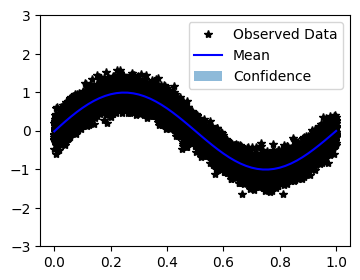

In [10]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])